# Predicción de los resultados en una campaña de publicidad

* En este ejercicio se practicaron técnicas de imputación de datos para datos no existentes, ejemplos avanzados de training y testing de datos y se realizaron las primeras medidas de calidad de modelos.
___________________________________________________________

- Importación del archivo de uso (Datos de Marketing para un Banco) del ej. Anterior 

In [1]:
import pandas as pd
import numpy as np
import os
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Lectura del archivo
os.chdir('C:/Users/estef/Desktop/data')
df = pd.read_csv('bank-additional-full.csv', sep = ';')
df.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
26759,51,admin.,divorced,university.degree,no,yes,yes,cellular,nov,thu,...,2,999,0,nonexistent,-0.1,93.200,-42.0,4.076,5195.8,no
40555,34,admin.,married,university.degree,no,yes,no,cellular,sep,wed,...,1,18,2,failure,-1.1,94.199,-37.5,0.886,4963.6,no
21665,50,admin.,married,basic.6y,no,no,no,cellular,aug,tue,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,no
20840,33,technician,single,professional.course,no,no,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,no
2605,46,blue-collar,married,unknown,unknown,yes,no,telephone,may,tue,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no


- Feature Engineering: Variables alto sesgo, Estandarización de variables https://towardsdatascience.com/how-and-why-to-standardize-your-data-996926c2c832

In [3]:
df.nunique()

age                 78
job                 12
marital              4
education            8
default              3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
duration          1544
campaign            42
pdays               27
previous             8
poutcome             3
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          316
nr.employed         11
y                    2
dtype: int64

In [4]:
categ_columns = [ 'default','housing','loan']
for column in categ_columns:
    print ('\n')
    print(df[column].value_counts())



default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64


housing
yes        21576
no         18622
unknown      990
Name: count, dtype: int64


loan
no         33950
yes         6248
unknown      990
Name: count, dtype: int64


In [5]:
#Asignar clases con poca representación
df['education'].replace({'unknown':'other','illiterate':'other'},inplace=True)
df['default'].replace({'unknown':'other','yes':'other'},inplace=True)

C:\Users\estef\AppData\Local\Temp\ipykernel_18816\3284725233.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['education'].replace({'unknown':'other','illiterate':'other'},inplace=True)
C:\Users\estef\AppData\Local\Temp\ipykernel_18816\3284725233.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

In [6]:
##### Antes de continuar con el análisis se modificarán las columnas de mes, día y resultado de la campaña (y) 
# para poder incluirlo en el análisis, se transforman también los datos de las columnas job, marital, education, 
# defaullt, housing, loan, poutcome, contact en categorias
#Meses
df['month'].replace({'apr': 4, 'aug': 8, 'dec': 12, 'jul': 7, 'jun': 6, 'mar': 3, 'may': 5, 'nov': 11, 'oct': 10, 'sep': 9}, inplace=True)
#Días
df['day_of_week'].replace({'fri': 5, 'mon': 1, 'thu': 4, 'tue': 2, 'wed': 3 }, inplace=True)
#Resultado de la campaña
df['y'].replace({'no': 0, 'yes': 1}, inplace=True)
#reemplazamos por 1 si ya habia sido contactado antes y 0 si no habia sido contactado antes en pday
df['pdays'] = df['pdays'].apply(lambda x: 1 if 1 <= x <= 30 else 0 if x == 999 else x)

df['job'] = df['job'].astype('category')
df['marital'] = df['marital'].astype('category')
df['education'] = df['education'].astype('category')
df['default'] = df['default'].astype('category')
df['housing'] = df['housing'].astype('category')
df['loan'] = df['loan'].astype('category')
df['poutcome'] = df['poutcome'].astype('category')
df['contact'] = df['contact'].astype('category')
df['pdays'] = df['pdays'].astype('category')


C:\Users\estef\AppData\Local\Temp\ipykernel_18816\1368035261.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['month'].replace({'apr': 4, 'aug': 8, 'dec': 12, 'jul': 7, 'jun': 6, 'mar': 3, 'may': 5, 'nov': 11, 'oct': 10, 'sep': 9}, inplace=True)
C:\Users\estef\AppData\Local\Temp\ipykernel_18816\1368035261.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behav

- Eliminar variables que tengan alta correlación y/o no sean necesarias 

In [7]:
def ColNum(x):
    numeric_columns = x.select_dtypes(include=['number'])
    return numeric_columns

df_num = ColNum(df)

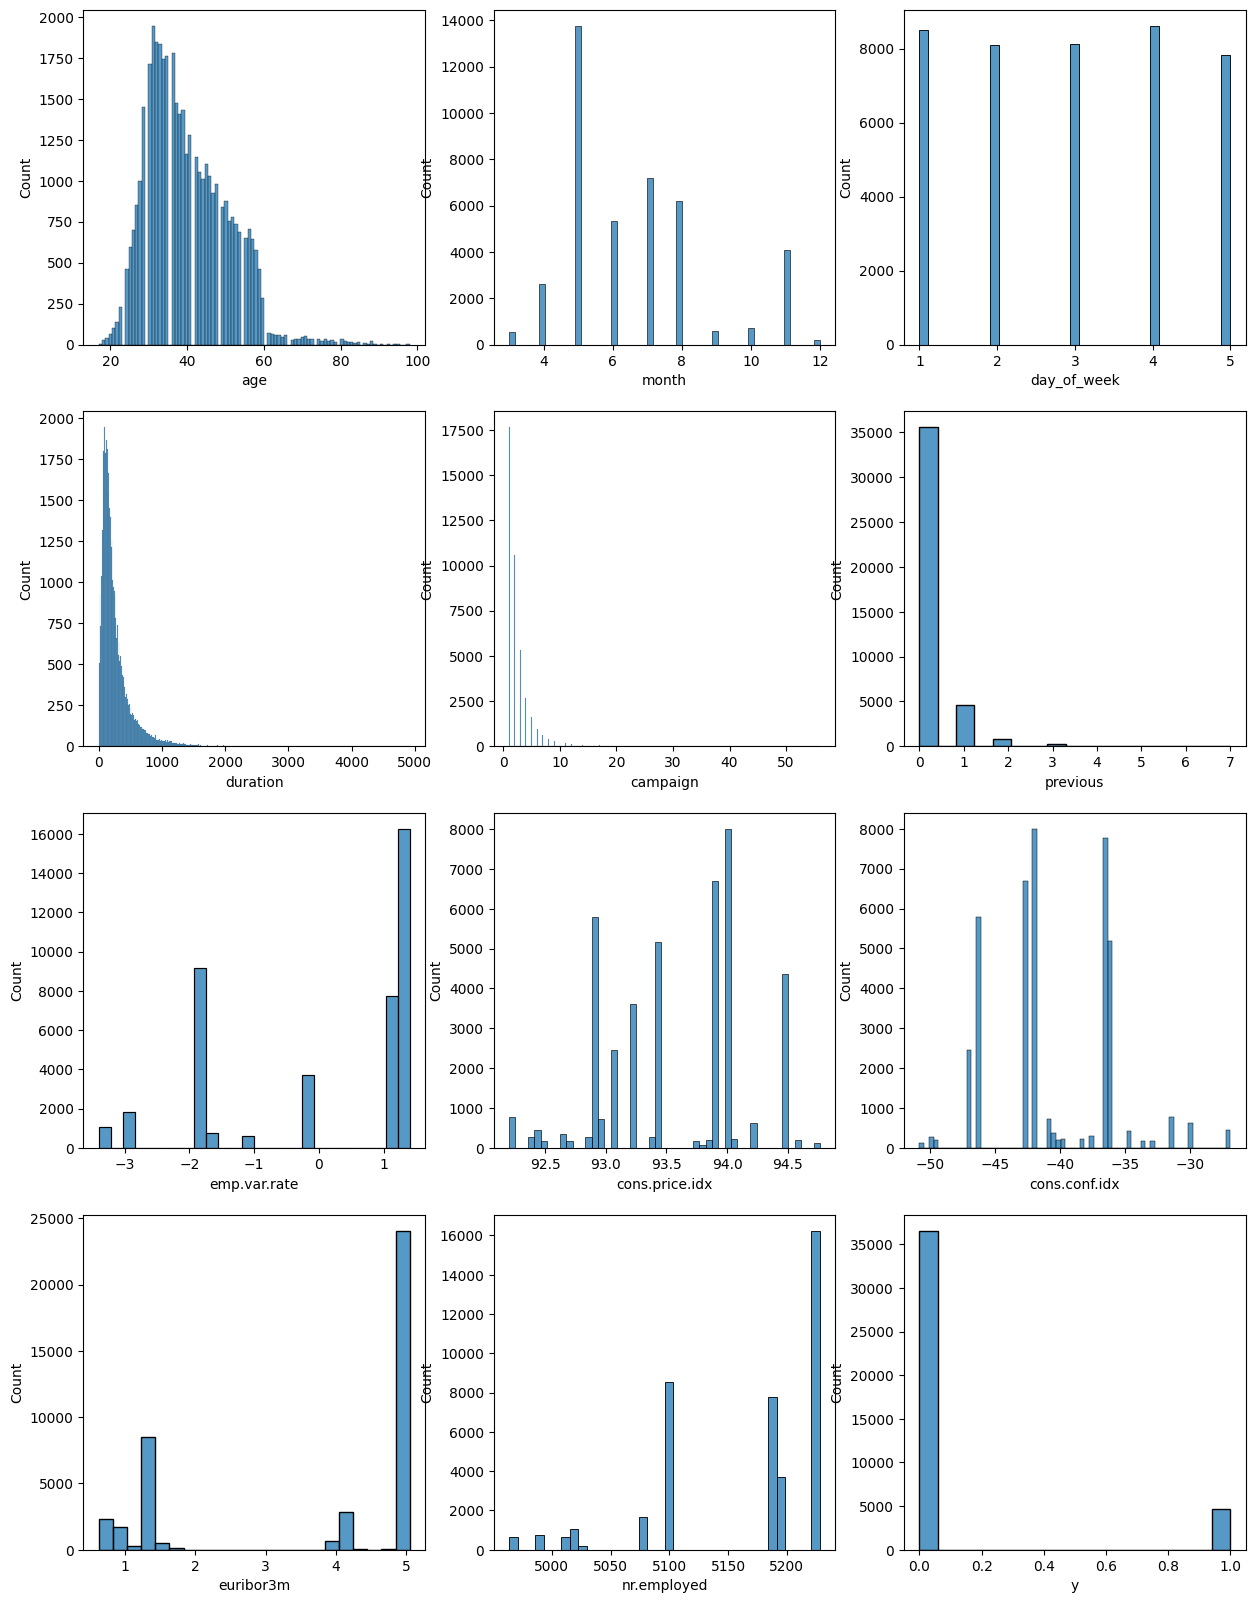

In [8]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15,20))
for i, column in enumerate(df_num):
    sns.histplot(df_num[column],ax=axes[i//3, i%3], kde=False)

In [10]:
#Hacemos una copia del df para hacer drOp a las columnas con demasiada correlación o que no aportan algo al análisis
df2 = df.copy()

In [11]:
#Las variables sesgadas son duration, campaign, previous por lo que se obtendrá variable log
#Tratamos variables que resultaron en una distribución muy sesgada como logaritmicas
##campaign, duration, previous
df2['campaign_log'] = np.log(df2['campaign']+1)
df2['duration_log'] = np.log(df2['duration']+1)
df2['previous_log'] = np.log(df2['previous']+1)

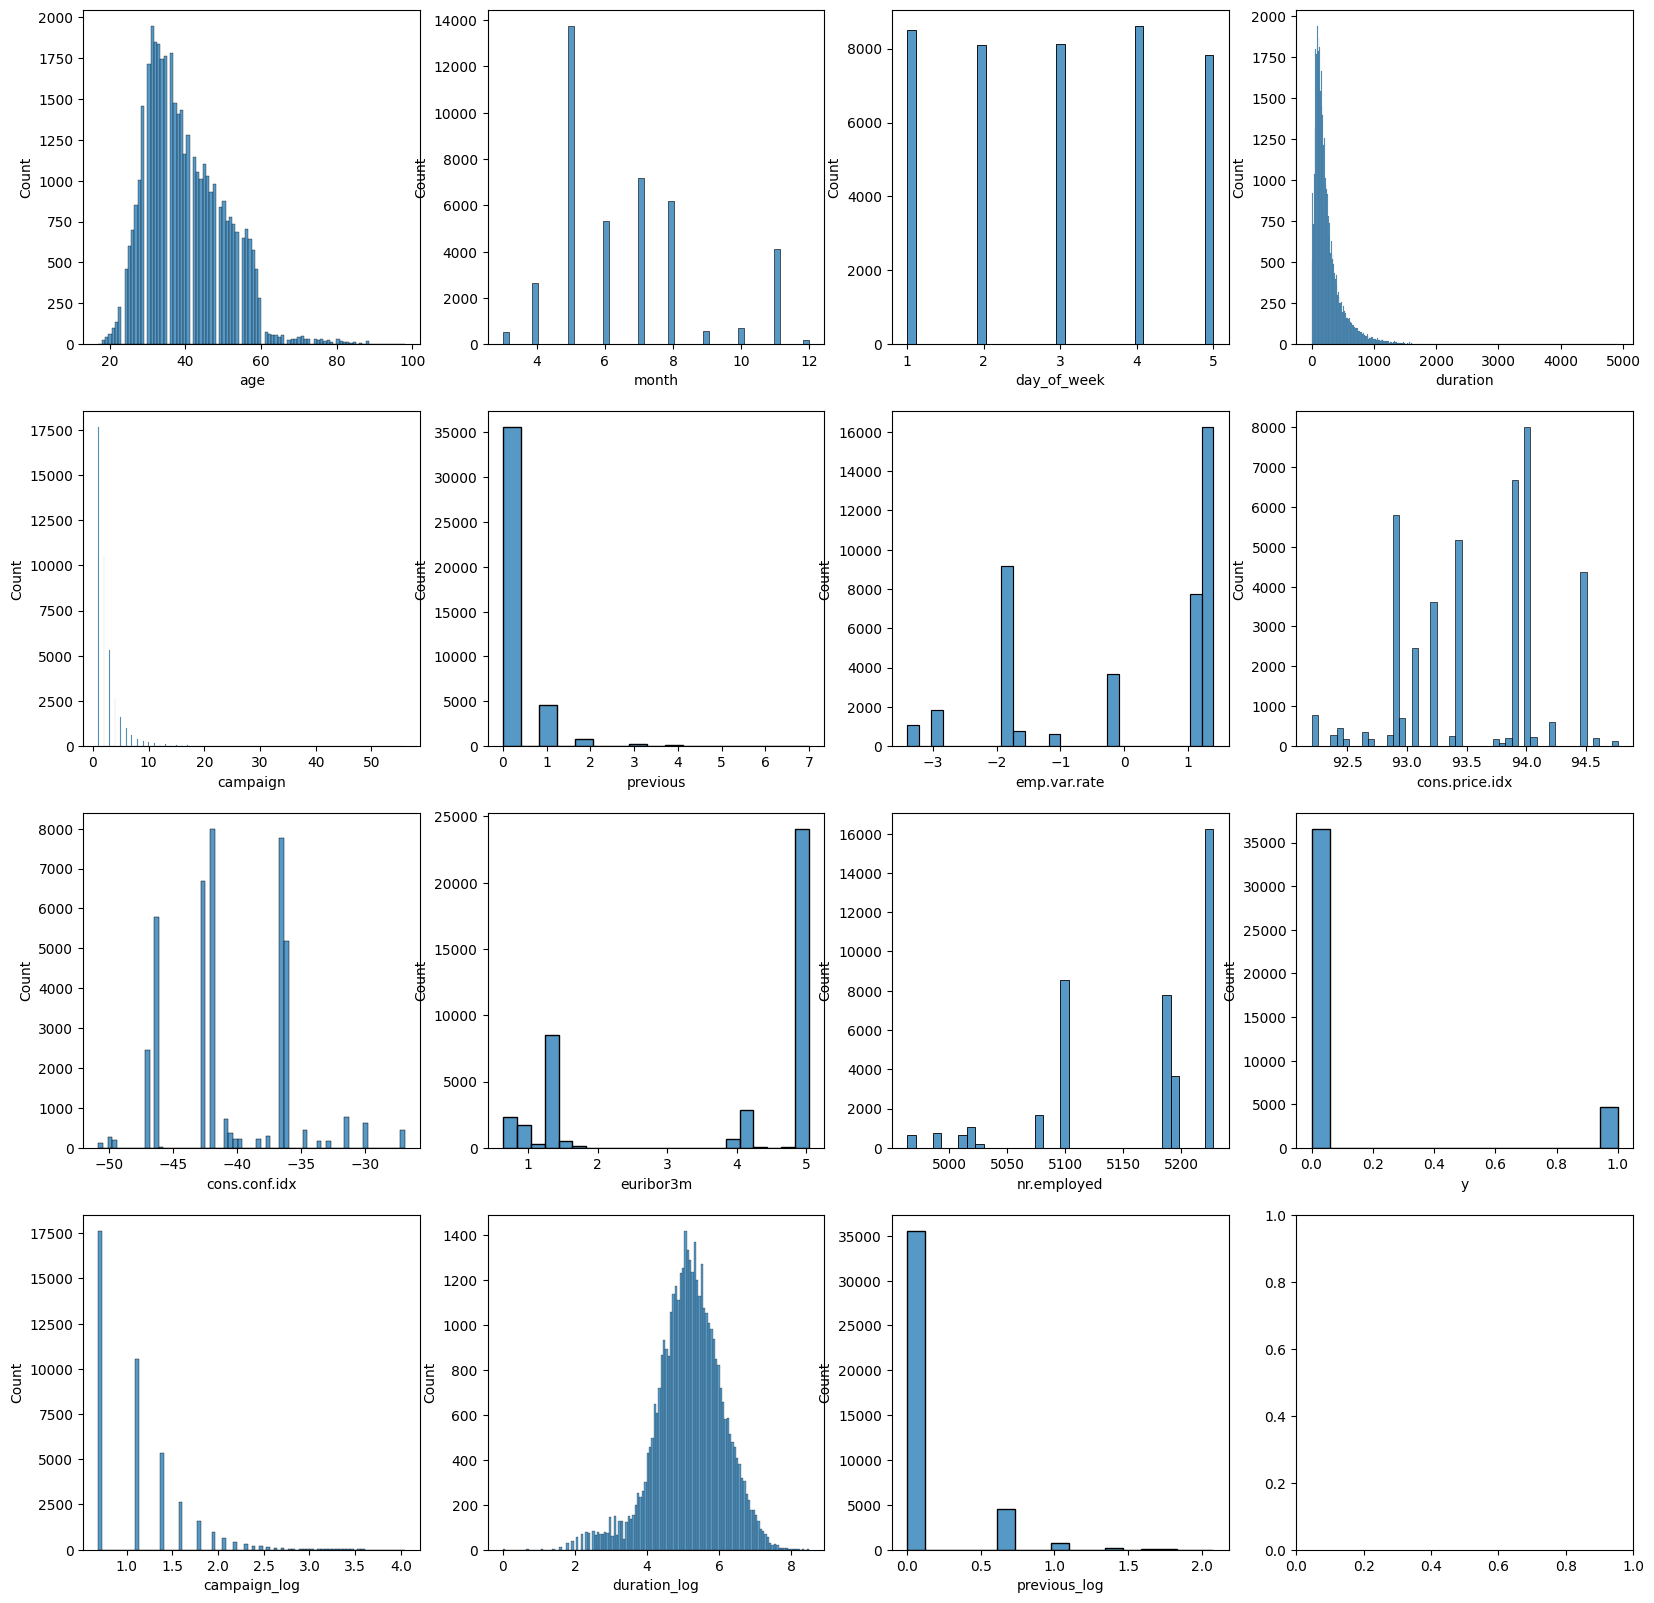

In [12]:
#visualizacion de las columnas log
df2_num = ColNum(df2)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20,20))
for i, column in enumerate(df2_num):
    sns.histplot(df2_num[column],ax=axes[i//4, i%4], kde=False)

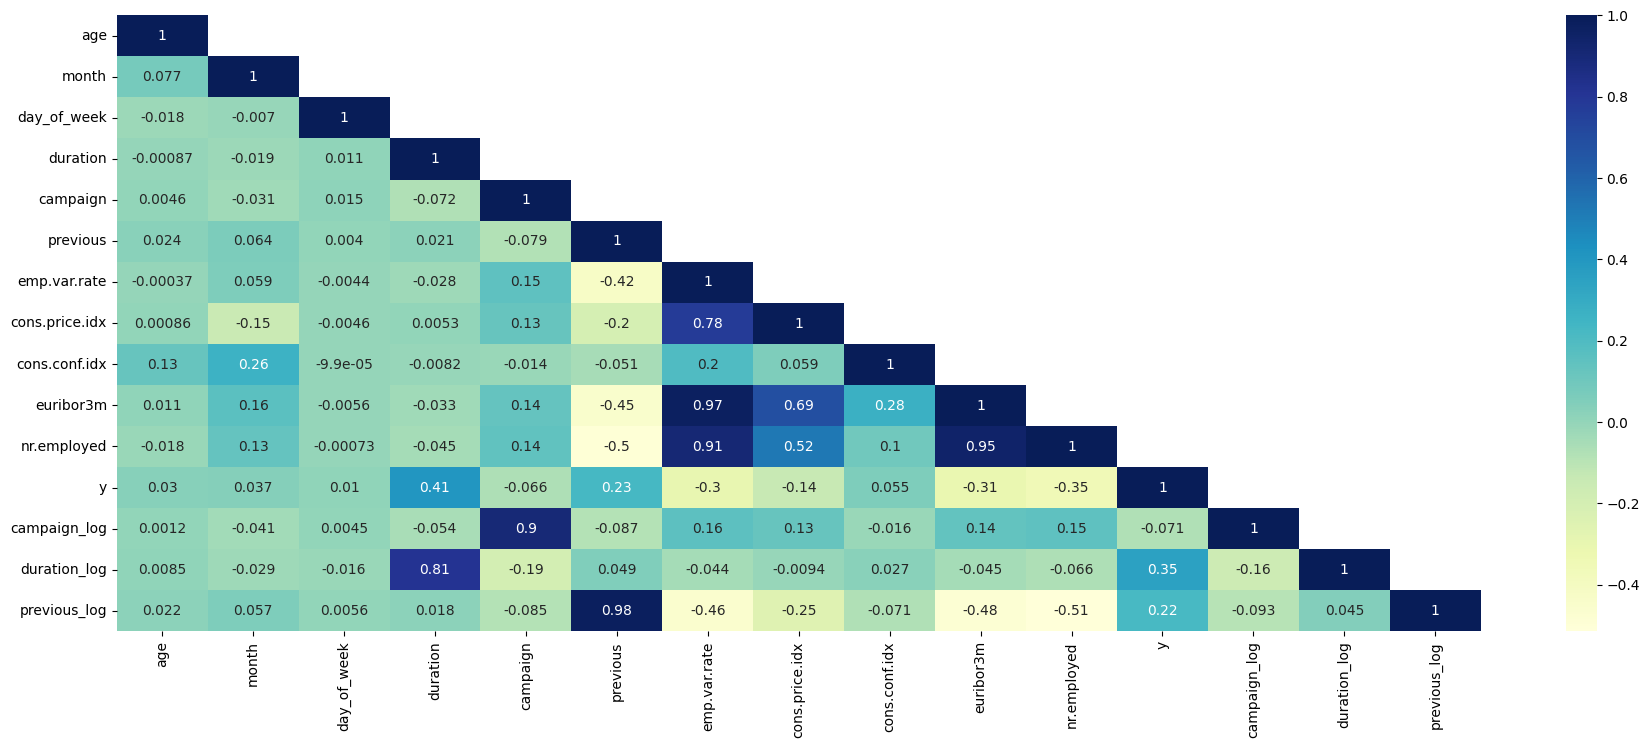

In [16]:
plt.figure(figsize=(22,8))  
corr_df2 = corr = df2_num.corr(method='pearson')
df2_lt = corr_df2.where(np.tril(np.ones(corr_df2.shape)).astype(bool))
hmap = sns.heatmap(df2_lt, cmap = 'YlGnBu', annot = True)

In [15]:
#Hacemos drop de las columnas con alta correlacion
df2.drop('emp.var.rate', axis=1, inplace = True)

- Generar set de training y test 70:30 

In [17]:
#Librería de split
from sklearn.model_selection import train_test_split

x = df2.drop('y', axis = 1)
y = df2['y']

x = pd.get_dummies(x, drop_first=True)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = 1)

In [20]:
x_train.head()

,age,month,day_of_week,duration,campaign,previous,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,education_university.degree,default_other,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,pdays_1,poutcome_nonexistent,poutcome_success
11196,38,6,4,149,1,0,94.465,-41.8,4.961,5228.1,...,False,True,False,False,False,False,True,False,True,False
15464,51,7,5,104,1,0,93.918,-42.7,4.957,5228.1,...,False,False,False,True,False,False,False,False,True,False
25538,45,11,3,770,1,0,93.200,-42.0,4.120,5195.8,...,True,False,False,True,False,False,False,False,True,False
13108,45,7,3,394,1,0,93.918,-42.7,4.962,5228.1,...,False,False,False,False,False,False,False,False,True,False
17088,34,7,5,1000,1,0,93.918,-42.7,4.962,5228.1,...,False,False,False,False,False,True,False,False,True,False


In [18]:
print("{0:0.2f}% data is in training set".format((len(x_train)/len(df2.index))*100))
print("{0:0.2f}% data is in test set".format((len(x_test)/len(df2.index))*100))

70.00% data is in training set
30.00% data is in test set


In [19]:
print("Original Personal Campaign True Values  : {0} ({1:0.2f}%)".format(len(df2.loc[df2['y']==1]),(len(df2.loc[df2['y']==1])/len(df2.index))*100))
print("Original Personal Campaign False Values : {0} ({1:0.2f}%)".format(len(df2.loc[df2['y']==0]),(len(df2.loc[df2['y']==0])/len(df2.index))*100))


print("Trainind Personal Campaign True Values  : {0} ({1:0.2f}%)".format(len(y_train[y_train[:]==1]),(len(y_train[y_train[:]==1])/len(y_train))*100))
print("Trainind Personal Campaign False Values  : {0} ({1:0.2f}%)".format(len(y_train[y_train[:]==0]),(len(y_train[y_train[:]==0])/len(y_train))*100))

print("Trainind Personal Campaign True Values  : {0} ({1:0.2f}%)".format(len(y_test[y_test[:]==1]),(len(y_test[y_test[:]==1])/len(y_test))*100))
print("Trainind Personal Campaign False Values  : {0} ({1:0.2f}%)".format(len(y_test[y_test[:]==0]),(len(y_test[y_test[:]==0])/len(y_test))*100))

Original Personal Campaign True Values  : 4640 (11.27%)
Original Personal Campaign False Values : 36548 (88.73%)
Trainind Personal Campaign True Values  : 3227 (11.19%)
Trainind Personal Campaign False Values  : 25604 (88.81%)
Trainind Personal Campaign True Values  : 1413 (11.43%)
Trainind Personal Campaign False Values  : 10944 (88.57%)


- Simple modelo de regresión logística

In [22]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight={0:0.15,1:0.85},solver = 'liblinear')
model.fit(x_train,y_train)

y_predict = model.predict(x_test)

In [23]:

y_predict[0:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [27]:
z = x_test.copy()
z['Response real'] = y_test
z['Response prediction'] = y_predict
z[['Response real','Response prediction']].head(40)

,Response real,Response prediction
35577,0,0
13950,0,0
29451,1,0
32295,0,0
27477,0,0
31507,0,0
32167,0,0
24580,0,0
2954,0,0
34998,0,0


- Matriz de Confusión y conclusiones del modelo

Text(0.5, 1.0, 'Matriz de Confusión')

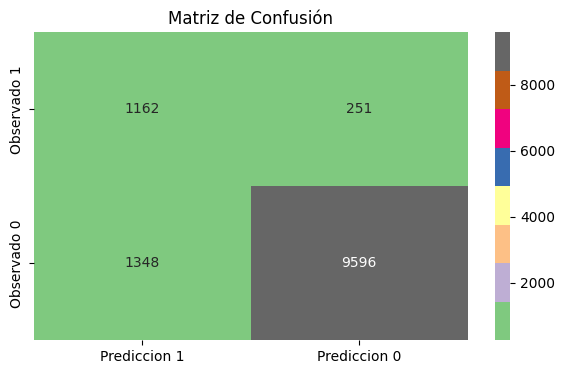

In [28]:
cm=metrics.confusion_matrix(y_test,y_predict,labels=[1,0])

df_cm = pd.DataFrame(cm, index=[i for i in ['Observado 1','Observado 0']],
                     columns = [i for i in ['Prediccion 1','Prediccion 0']])

plt.figure(figsize = (7,4))
sns.heatmap(df_cm, annot=True,cmap='Accent',fmt='d').set_title('Matriz de Confusión')

In [29]:
df_cm

,Prediccion 1,Prediccion 0
Observado 1,1162,251
Observado 0,1348,9596


- Cálculo de primeras medidas de calidad del modelo: Accuracy, Precision, Recall, F1 

In [31]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix

y_pred = model.predict(x_test)
model_score = accuracy_score(y_test, y_pred)
recall_score = recall_score(y_test, y_pred)
precision_score = precision_score(y_test, y_pred)
f1_score = f1_score(y_test,y_pred)

print('Medidas del Modelo')
print('Accuracy = {0:0.2f}'.format(model_score))
print('Precision = {0:0.2f}'.format(precision_score))
print('Recall = {0:0.2f}'.format(recall_score))
print('F1 Score = {0:0.2f}'.format(f1_score))
print('Roc Auc Score = {0:0.2f}'.format(roc_auc_score(y_test,y_pred)))

Medidas del Modelo
Accuracy = 0.87
Precision = 0.46
Recall = 0.82
F1 Score = 0.59
Roc Auc Score = 0.85
